In [53]:
# from myreport import html_report
from IPython.display import HTML
tog='''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''';

def init_esplot():
    plt.close('all');
    fig=plt.figure(figsize=[10, 4]);
    ax=plt.subplot(1,1,1)
    return(ax,fig)
HTML(tog)


In [2]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import copy
import math

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import sys

global IPTG

cmd_init_name='''
varname=['p_LacI','p_TetR','p_CI','m_LacI','m_TetR','m_CI','m_GFP','p_GFP'];
cstname=['k_m','k_m0','k_p','k_dm','k_dp','K','n','k_dGFP','IPTG'];
'''
cmd_name2dict='''
vardict={x:varname.index(x) for x in varname};
cstdict={x:cstname.index(x) for x in cstname};
'''
make_init_cmd = lambda varname,cstname:'s0=(%s);param = (%s);'% (','.join(varname),','.join(cstname));
make_unpack_cmd = lambda varname,cstname:'(%s)=s;(%s)=param;'% (','.join(varname),','.join(cstname));
make_pack_cmd = lambda varname,cstname: 'sdot=(%s);'%(','.join(['d'+x for x in varname]))
make_unpackobs_cmd = lambda vardict:''.join( '%s_obs = s_obs[:,%s];' % (key,val) for key,val in vardict.items());

exec(cmd_init_name)
exec(cmd_name2dict)


cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
cmd_unpack_obs
# cmd_pack_all



'p_LacI_obs = s_obs[:,0];m_TetR_obs = s_obs[:,4];m_LacI_obs = s_obs[:,3];p_CI_obs = s_obs[:,2];m_CI_obs = s_obs[:,5];p_TetR_obs = s_obs[:,1];m_GFP_obs = s_obs[:,6];p_GFP_obs = s_obs[:,7];'

In [161]:
# cmd_unpack_var='(' + ','.join(varname)+') ='+'s;';
# cmd_unpack_cst='(' + ','.join(cstname)+') ='+'param;';

def sdot(s,t,param):

#     (p_LacI, p_TetR, p_CI, m_LacI, m_TetR, m_CI, m_GFP, p_GFP)=s
#     (k_m, k_m0, k_p, k_dm, k_dp, K, n, k_dGFP, IPTG,fix_conc)=param
    exec(cmd_unpack_all)

#     if not fix_list==None:
#     print(fix_list)
    
#     for var_ind in fix_list:
#         cmd=varname[var_ind] + ' = (fix_conc[var_ind])';
#         exec(cmd);
#         print(cmd)
#         print(var_ind)
        

    rate_m_LacI_prod = k_m*K**n / (K**n + p_CI**n)   + k_m0
    if IPTG_method == None:
        rate_m_TetR_prod = k_m*K**n / (K**n + p_LacI**n) + k_m0
    if IPTG_method == 'multiply':
        rate_m_TetR_prod = k_m*K**n / (K**n + p_LacI**n) * K**n/(K**n + IPTG) + k_m0
    if IPTG_method == 'add':
        rate_m_TetR_prod = k_m*K**n / (K**n + (p_LacI + IPTG)**n) + k_m0
    rate_m_CI_prod   = k_m*K**n / (K**n + p_TetR**n) + k_m0
    rate_m_GFP_prod  = 0

    rate_p_LacI_prod = k_p*m_LacI
    rate_p_TetR_prod = k_p*m_TetR
    rate_p_CI_prod   = k_p*m_CI
    rate_p_GFP_prod  = 0

    rate_m_LacI_loss = k_dm*m_LacI
    rate_m_TetR_loss = k_dm*m_TetR
    rate_m_CI_loss   = k_dm*m_CI
    rate_m_GFP_loss  = 0

    rate_p_LacI_loss = k_dp*p_LacI
    rate_p_TetR_loss = k_dp*p_TetR
    rate_p_CI_loss   = k_dp*p_CI
    rate_p_GFP_loss  = 0

    dp_LacI = rate_p_LacI_prod - rate_p_LacI_loss
    dp_TetR = rate_p_TetR_prod - rate_p_TetR_loss
    dp_CI   = rate_p_CI_prod   - rate_p_CI_loss
    dp_GFP  = rate_p_GFP_prod  - rate_p_GFP_loss


    dm_LacI = rate_m_LacI_prod - rate_m_LacI_loss
    dm_TetR = rate_m_TetR_prod - rate_m_TetR_loss
    dm_CI   = rate_m_CI_prod   - rate_m_CI_loss
    dm_GFP  = rate_m_GFP_prod   - rate_m_GFP_loss

    exec(cmd_pack_all)
    return sdot


cmd_default_incond='''
p_LacI=0
p_TetR=0
p_CI=0
p_GFP=0

m_LacI=5
m_TetR=0
m_CI=0
m_GFP=0
'''

cmd_pack_incond='s0 = (p_LacI, p_TetR, p_CI, m_LacI, m_TetR, m_CI, m_GFP, p_GFP)';

cmd_default_param='''
k_m=0.5
k_m0=5e-4

K=40.0
n=2.1

k_dm=0.00577622650467
k_dp=0.00144405662617
k_dGFP=0.000128360588993
k_p=0.115524530093
'''

cmd_pack_param='''fix_conc=s0; param = (k_m, k_m0, k_p, k_dm, k_dp, K, n, k_dGFP, IPTG)''';


cmd_unpack_obs='''
p_LacI_obs = s_obs[:,0]
p_TetR_obs = s_obs[:,1]
p_CI_obs   = s_obs[:,2]
m_LacI_obs = s_obs[:,3]
m_TetR_obs = s_obs[:,4]
m_CI_obs   = s_obs[:,5]
m_GFP_obs   = s_obs[:,6]
p_GFP_obs   = s_obs[:,7]
'''



/home/shouldsee/.local/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


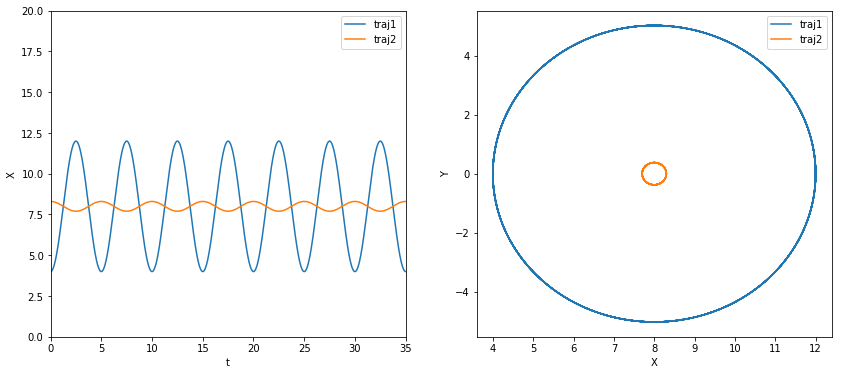

In [3]:
execfile('oscillator1.py')



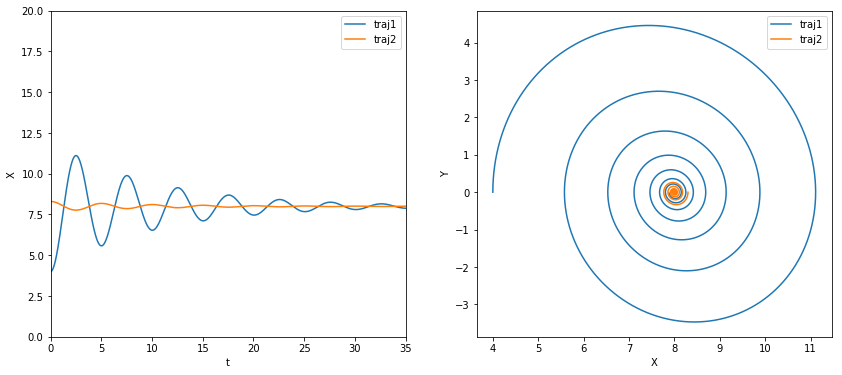

In [4]:
# %matplotlib notebook
%matplotlib inline
execfile('oscillator2.py')


5.82398058038


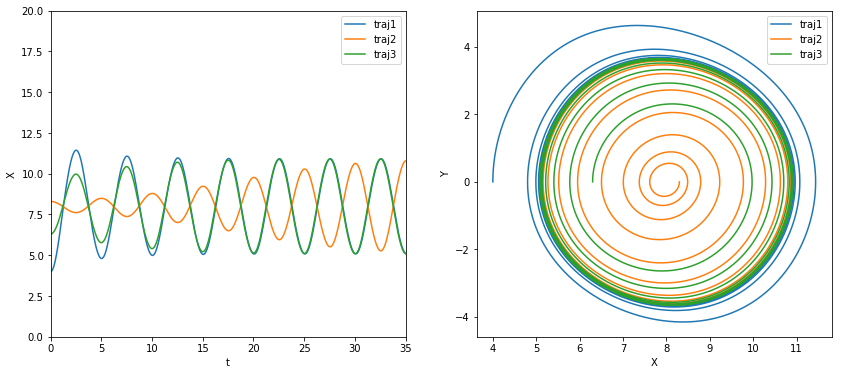

In [5]:
execfile('oscillator3.py')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:76: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


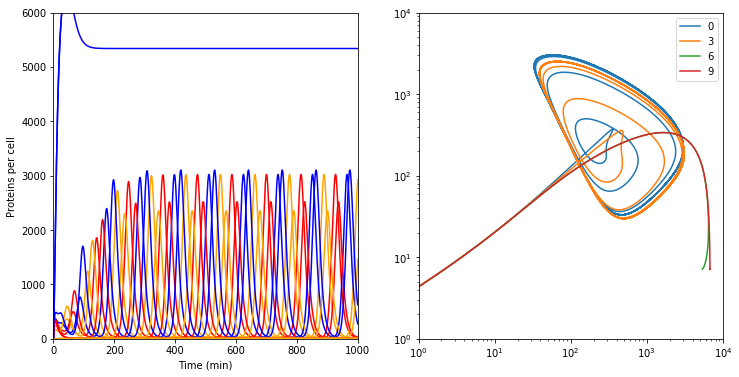

In [43]:
IPTG=10E4
execfile('repressilator.py')

plt.close("all")
fig1 = plt.figure(figsize=(12,6))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)

axL.legend();
axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
# ys = p_GFP_obs;

for level in range(0,9+1,3):
    IPTG=10**(level);
    execfile('repressilator.py')

    axL.set_xlim(0,1000)
    axL.set_ylim(0,6000)
    axL.set_xlabel('Time (min)')
    axL.set_ylabel('Proteins per cell')
    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI')
    axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
    axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
#     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,label=str(level))

    axR.set_xscale('log')
    axR.set_yscale('log')
    axR.set_xlim(1,1E4)
    axR.set_ylim(1,1E4)
    axR.legend()

    # axL.set_xlim(0,1000)
    # axL.set_ylim(0,6000)



fig1.savefig('repressilator.png')


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


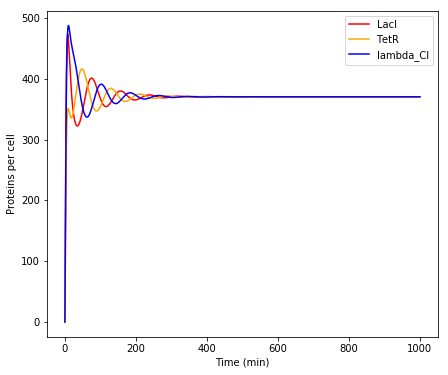

In [7]:
# n = 1.3
execfile('repressilator2.py')

plt.close("all")
fig1 = plt.figure(figsize=(7,6))
axL=fig1.add_subplot(1,1,1)
axL.legend();
axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
# ys = p_GFP_obs;
# axL.set_xlim(0,1000)
# axL.set_ylim(0,6000)
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI')
axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
axL.legend()
fig1.savefig('repressilator2.png')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


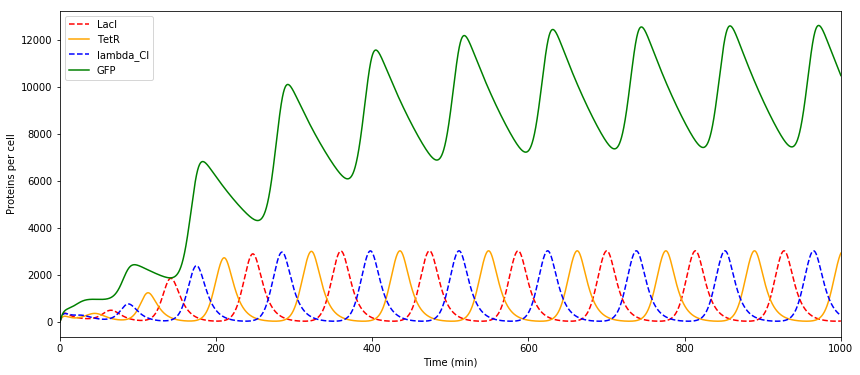

In [61]:
# n = 1.3
execfile('repressilator_GFP.py')

plt.close("all")
fig1 = plt.figure(figsize=(14,6))
axL=fig1.add_subplot(1,1,1)
# axR=fig1.add_subplot(2,1,2)
axL.legend();
axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
ys = p_GFP_obs;
axL.set_xlim(0,1000)
# axL.set_ylim(0,6000)
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
axL.plot(t_obs/60,p_LacI_obs,'r--',label = 'LacI')
axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
axL.plot(t_obs/60,p_CI_obs,'b--', label = 'lambda_CI')
axL.plot(t_obs/60,p_GFP_obs ,'g',label = 'GFP')

axL.legend()

# axR.set_xlim(0,1000)
# axR.set_ylim(0,6000)
# axR.set_xlabel('Time (min)')
# axR.set_ylabel('Proteins per cell')
# axR.plot(t_obs/60,p_GFP_obs ,'g',label = 'GFP')
# axR.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
# axR.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
# axR.legend()

fig1.savefig('repressilator_GFP.png')

In [62]:
# half-life to rate
-math.log(2)/(90*60)

-0.00012836058899258246

In [63]:
execfile('repressilator_stoch.py')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:317: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


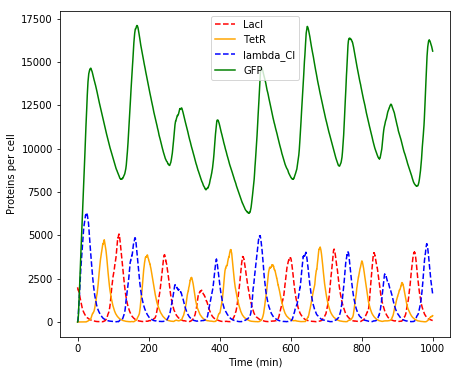

In [64]:
%matplotlib inline
plt.close("all")
fig1 = plt.figure(figsize=(7,6))
axL=fig1.add_subplot(1,1,1)
# axR=fig1.add_subplot(2,1,2)
axL.legend();
# axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
ys = p_GFP_obs;
# axL.set_xlim(0,1000)
# axL.set_ylim(0,6000)
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
axL.plot(t_obs/60,p_LacI_obs,'r--',label = 'LacI')
axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
axL.plot(t_obs/60,p_CI_obs,'b--', label = 'lambda_CI')
axL.plot(t_obs/60,p_GFP_obs ,'g',label = 'GFP')
axL.legend()

fig1.show()

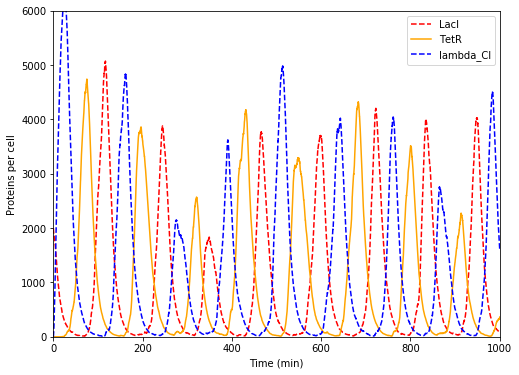

In [65]:
%matplotlib inline
plt.close("all")
fig1 = plt.figure(figsize=(8,6))
axL=fig1.add_subplot(1,1,1)
# axR=fig1.add_subplot(2,1,2)
axL.legend();
# axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
ys = p_GFP_obs;
axL.set_xlim(0,1000)
axL.set_ylim(0,6000)
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
axL.plot(t_obs/60,p_LacI_obs,'r--',label = 'LacI')
axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
axL.plot(t_obs/60,p_CI_obs,'b--', label = 'lambda_CI')
# axL.plot(t_obs/60,p_GFP_obs ,'g',label = 'GFP')
axL.legend()

fig1.show()
fig1.savefig('rep_stochastic.png')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


# runs in output: 100
# observations in each run 6001


(6001, 8)

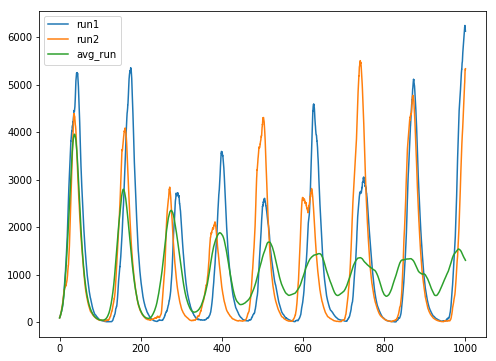

In [66]:
execfile('repressilator_analysis.py')
# plt.close("all")
# fig1 = plt.figure(figsize=(8,6))
# axL=fig1.add_subplot(1,1,1)
# # axR=fig1.add_subplot(2,1,2)
# axL.legend();
# # axR.legend();

# runnum=0;
# for s_obs in output[:7]:
#     runnum+=1;
#     p_LacI_obs = s_obs[:,0]
#     p_TetR_obs = s_obs[:,1]
#     p_CI_obs   = s_obs[:,2]
#     m_LacI_obs = s_obs[:,3]
#     m_TetR_obs = s_obs[:,4]
#     m_CI_obs   = s_obs[:,5]
#     m_GFP_obs   = s_obs[:,6]
#     p_GFP_obs   = s_obs[:,7]
#     axL.plot(t_obs/60,p_LacI_obs,label = 'run'+str(runnum))

# axL.set_xlabel('Time (min)')
# axL.set_ylabel('LacI Proteins per cell')
# axL.legend()
# fig1.savefig('rep_runs.png')
avg = output.mean(axis = 0);
avg.shape


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:77: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


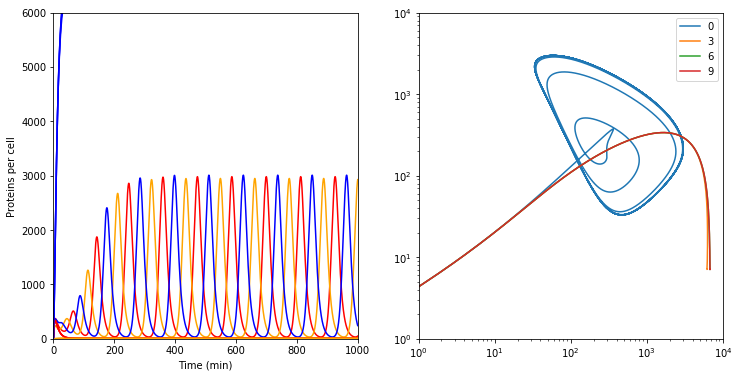

In [49]:
IPTG=10E4
execfile('repressilator.py')

plt.close("all")
fig1 = plt.figure(figsize=(12,6))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)

axL.legend();
axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
# ys = p_GFP_obs;

for level in range(0,9+1,3):
    IPTG=10**(level);
    execfile('repressilator.py')

    axL.set_xlim(0,1000)
    axL.set_ylim(0,6000)
    axL.set_xlabel('Time (min)')
    axL.set_ylabel('Proteins per cell')
    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI')
    axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
    axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
#     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,label=str(level))

    axR.set_xscale('log')
    axR.set_yscale('log')
    axR.set_xlim(1,1E4)
    axR.set_ylim(1,1E4)
    axR.legend()

    # axL.set_xlim(0,1000)
    # axL.set_ylim(0,6000)



fig1.savefig('repressilator.png')


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:76: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


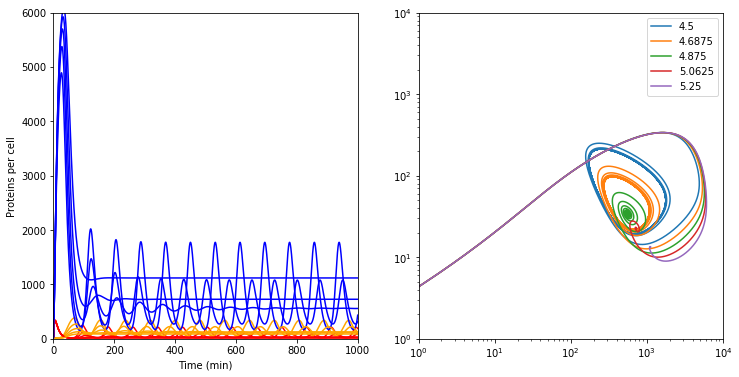

In [48]:
IPTG=10E4
execfile('repressilator.py')

plt.close("all")
fig1 = plt.figure(figsize=(12,6))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)

axL.legend();
axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
# ys = p_GFP_obs;
IPTG_method='multiply'

for level in np.linspace(4.5,5.25,5):
    IPTG=10**(level);
    execfile('repressilator.py')

    axL.set_xlim(0,1000)
    axL.set_ylim(0,6000)
    axL.set_xlabel('Time (min)')
    axL.set_ylabel('Proteins per cell')
    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI')
    axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
    axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
#     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,label=str(level))

    axR.set_xscale('log')
    axR.set_yscale('log')
    axR.set_xlim(1,1E4)
    axR.set_ylim(1,1E4)
    axR.legend()

    # axL.set_xlim(0,1000)
    # axL.set_ylim(0,6000)



fig1.savefig('repressilator.png')


IPTG=10E4
# execfile('repressilator.py')

plt.close("all")
fig1 = plt.figure(figsize=(12,6))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)

axL.legend();
axR.legend();
fig1.show()
ys = m_TetR_obs;
ys = s_obs[:,0];
# ys = p_GFP_obs;

IPTG_method='add';

for level in np.linspace(0,3,5):
    IPTG=10**(level);
#     execfile('repressilator.py')
    s_obs=rep_det(IPTG_method='add');
#     rep_det()
    
    exec(cmd_unpack_obs)

    axL.set_xlim(0,1000)
    axL.set_ylim(0,6000)
    axL.set_xlabel('Time (min)')
    axL.set_ylabel('Proteins per cell')
    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI')
    axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
    axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
#     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,label=str(level))

    axR.set_xscale('log')
    axR.set_yscale('log')
    axR.set_xlim(1,1E4)
    axR.set_ylim(1,1E4)
    axR.legend()

    # axL.set_xlim(0,1000)
    # axL.set_ylim(0,6000)



fig1.savefig('repressilator.png')


<IPython.core.display.Javascript object>


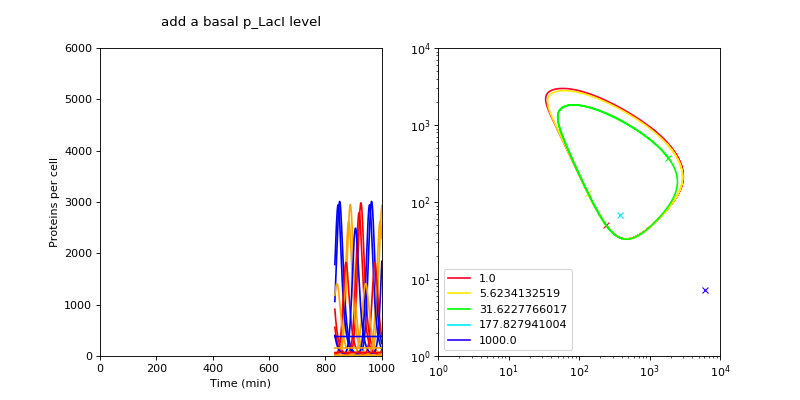

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [260]:
# add a basal p_LacI level
tl='''
add a basal p_LacI level
'''
%matplotlib notebook
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG_method='add';

exec(cmd_init_name)
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);

lc_step = 10000;

siz=5;
for i,log_par in enumerate(np.linspace(0.,3.,siz)):
    col=cm(1.*i/(siz));
    
    exec(cmd_default_param)
    exec(cmd_default_incond)
    IPTG=10**(log_par)
#     p_LacI = 10**(log_par)
    exec(cmd_pack_incond)
    exec(cmd_pack_param)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI')
    axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
    axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=str(10**(log_par)))
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)


axL.set_xlim(0,1000)
axL.set_ylim(0,6000)
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')


axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()
    

<IPython.core.display.Javascript object>


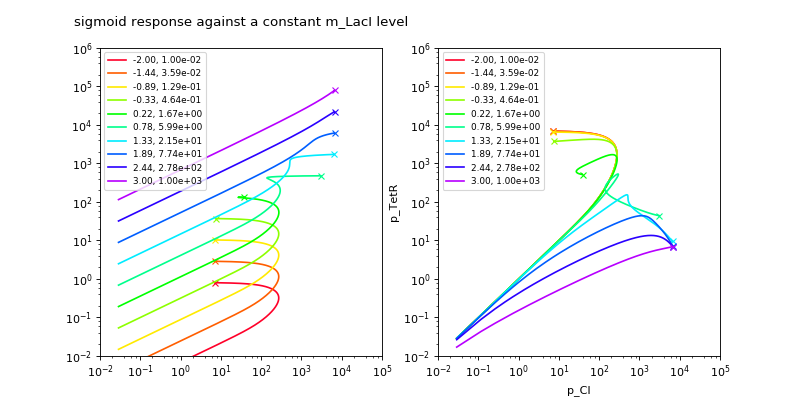

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [254]:
# sigmoid response against a constant m_LacI level
# sigmoid response against a constant m_LacI level
tl='''
sigmoid response against a constant m_LacI level
'''

%matplotlib notebook
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
IPTG_method=None;
IPTG=0
    
exec(cmd_init_name)
exec(cmd_name2dict)
parname = 'm_LacI'
varname.pop(vardict[parname])
cstname.append(parname)
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)



# lc_step = 10000;
lc_step = int(t_max)

cm = plt.get_cmap('gist_rainbow')

siz=10;

# k_dp=0.0014
for i,log_par in enumerate(np.linspace(-2.,3.,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    

    exec(cmd_default_param)
    exec(cmd_default_incond)
    m_LacI = 10**(log_par)
    exec(cmd_init_all)
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    

    xs=p_CI_obs;ys=p_LacI_obs;

    axL.plot(xs,ys,color=col,label=lbl)
    axL.plot(xs[-1],ys[-1],'x',color=col)
    
    xs=p_CI_obs;ys=p_TetR_obs;
    
    axR.plot(xs,ys,color=col,label=lbl)
    axR.plot(xs[-1],ys[-1],'x',color=col)
    
axL.set_xscale('log')
axL.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_LacI')
axL.set_xlim(1E-2,1E5)
axL.set_ylim(1E-2,1E6)
axL.legend(loc=2,prop={'size':8})

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_TetR')
axR.set_xlim(1E-2,1E5)
axR.set_ylim(1E-2,1E6)
axR.legend(loc=2,prop={'size':8})

In [239]:
cmd_unpack_obs

'm_TetR_obs = s_obs[:,3];m_LacI_obs = s_obs[:,2];p_CI_obs = s_obs[:,1];m_CI_obs = s_obs[:,4];p_TetR_obs = s_obs[:,0];m_GFP_obs = s_obs[:,5];p_GFP_obs = s_obs[:,6];'

<IPython.core.display.Javascript object>


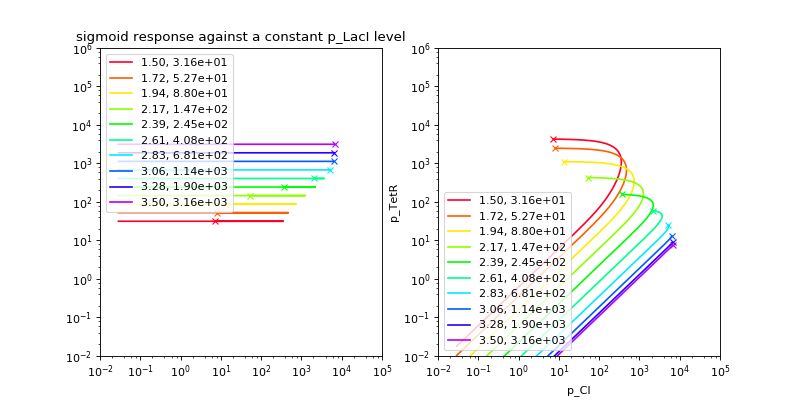

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [264]:
# sigmoid response against a constant p_LacI level
tl='sigmoid response against a constant p_LacI level';

%matplotlib notebook
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);

IPTG_method=None;
IPTG=0
    
exec(cmd_init_name)
exec(cmd_name2dict)
parname = 'p_LacI'
varname.pop(vardict[parname])
cstname.append(parname)
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)


t_obs=np.linspace(0,t_max,t_max+1)

lc_step = int(t_max);

cm = plt.get_cmap('gist_rainbow')

siz=10;

# k_dp=0.0014
for i,log_par in enumerate(np.linspace(1.5,3.5,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    

    exec(cmd_default_param)
    exec(cmd_default_incond)
    p_LacI = 10**(log_par)
    exec(cmd_init_all)
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    

    xs=p_CI_obs;ys=len(xs)*[p_LacI];

    axL.plot(xs,ys,color=col,label=lbl)
    axL.plot(xs[-1],ys[-1],'x',color=col)
    
    xs=p_CI_obs;ys=p_TetR_obs;
    
    axR.plot(xs,ys,color=col,label=lbl)
    axR.plot(xs[-1],ys[-1],'x',color=col)


axL.set_xscale('log')
axL.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_LacI')
axL.set_xlim(1E-2,1E5)
axL.set_ylim(1E-2,1E6)
axL.legend()

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_TetR')
axR.set_xlim(1E-2,1E5)
axR.set_ylim(1E-2,1E6)
axR.legend()

<IPython.core.display.Javascript object>


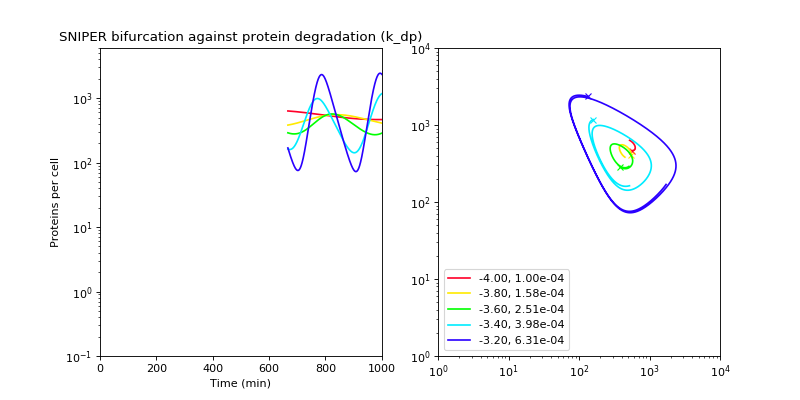

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [266]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
%matplotlib notebook
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
lc_step = 20000;



siz=5;


for i,log_par in enumerate(np.linspace(-4.,-3.2,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
    k_dp=10**(log_par)
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    


    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1E-1,1000)
axL.set_ylim(1E-1,6000)
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

In [4]:
import numpy as np
np.random.multinomial(1,np.array([[0,1],[2,3]]))

ValueError: object too deep for desired array